In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_curve, auc, make_scorer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import cross_val_score, GroupKFold, LeaveOneGroupOut
from sklearn.preprocessing import LabelEncoder

In [2]:
# 数据前处理
# Function to prepare the data for model training and evaluation
def data_prepare(disease_data, dataset):
    # Selecting the subset of data corresponding to the specified dataset
    train_x_pre = disease_data[disease_data['Project'] == dataset]
    
    # Generating a binary target variable where 1 indicates the presence of the disease
    # and 0 indicates the absence, while preserving the index order
    train_y = pd.Series((train_x_pre['Group'] == 'Disease').astype(int), index=train_x_pre.index)
    
    # Dropping unnecessary columns to isolate features for model training
    train_x = train_x_pre.drop(columns=['Sample', "BioProject", "Type", "Group", "LevelB", "LevelB1", "Project", "LevelA2", "LevelA3"])
    
    return train_x, train_y

In [3]:
# 数据前处理（需要标准化的数据）
# Function to prepare the data for model training and evaluation
def data_std_sub_prepare(disease_data, dataset):
    # Selecting the subset of data corresponding to the specified dataset
    train_x_pre = disease_data[disease_data['Project'] == dataset]
    
    # Generating a binary target variable where 1 indicates the presence of the disease
    # and 0 indicates the absence, while preserving the index order
    train_y = pd.Series((train_x_pre['Group'] == 'Disease').astype(int), index=train_x_pre.index)
    
    # Dropping unnecessary columns to isolate features for model training
    train_x = train_x_pre.drop(columns=['Sample', "BioProject", "Type", "Group", "LevelB", "LevelB1", "Project", "LevelA2", "LevelA3"])
    
    
    return train_x, train_y

In [4]:
## 随机森林预测
# 初始化StratifiedKFold
def random_forest(train_x, train_y):
    skf = StratifiedKFold(n_splits=10, shuffle=True)
    roc_auc_scores = []  # 存储每个折叠的ROC AUC分数
    # 遍历每个折叠
    for fold, (idxT, idxV) in enumerate(skf.split(train_x, train_y)):
        # 分割数据
        X_train = train_x.iloc[idxT]
        X_val = train_x.iloc[idxV]
        y_train = train_y.iloc[idxT]
        y_val = train_y.iloc[idxV]
        
        # 训练随机森林模型
        clf = RandomForestClassifier(n_estimators=5000, random_state=42)
        clf.fit(X_train, y_train)
        
        # 预测验证集
        y_pred = clf.predict_proba(X_val)[:, 1]
        
        # 计算ROC AUC分数
        roc_auc = roc_auc_score(y_val, y_pred)
        roc_auc_scores.append(roc_auc)
        
        # print(f"Fold {fold+1} ROC AUC: {roc_auc}")

    # 计算ROC AUC分数的平均值和标准差
    mean_roc_auc = np.mean(roc_auc_scores)
    std_dev_roc_auc = np.std(roc_auc_scores)

    # print(f"平均ROC AUC: {mean_roc_auc}")
    # print(f"ROC AUC的标准差: {std_dev_roc_auc}")
    return mean_roc_auc, std_dev_roc_auc


## 每个数据集内部预测，使用10-fold方法进行预测
def data_own_pred_rf(rawdata, prj):
    res = []
    data_mat, binary_target = data_prepare(rawdata, prj)
    # print(data_mat.shape[0], data_mat.shape[1])
    mean_roc_auc, std_dev_roc_auc = random_forest(data_mat, binary_target)
    print("%s Avg.ROC is %s, STD is %s"%(prj, mean_roc_auc, std_dev_roc_auc))
    return mean_roc_auc, std_dev_roc_auc


In [5]:
# 导入数据
df = pd.read_csv('02_species_abundance_v3.sum', sep='\t', index_col = 0)

# 去除第一行unmapped
df = df.iloc[1:]

# read_count table
df_count = df.filter(regex='Read Count')
df_count.columns = df_count.columns.str.replace('.filt Read Count', '')

## 读取Mapping 文件
mp = pd.read_csv('mapping.txt.f1', sep='\t')

In [6]:
## 对数据进行清洗和标准化
## 小于10条reads的菌株变为0
## 删除总数小于100条FLAB的样本
## 将每个样本的reads 进行百分比标准化
df_count[df_count < 5] = 0
df_count_filt = df_count.loc[:, df_count.sum() >= 100] # 删除总数小于100条的样本

df_count_filt.to_csv("df_count_filt.csv")

## 标准化
df_count_filt = df_count_filt.div(df_count_filt.sum(axis=0), axis=1) * 100

df_count_filt.to_csv("df_count_filt_rb.csv")

/tmp/ipykernel_244833/2080040821.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_count[df_count < 5] = 0
/tmp/ipykernel_244833/2080040821.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_count[df_count < 5] = 0


In [7]:
## 使用相对含量
df_count_input = df_count_filt.T
## 为样本加上Label
df_count_input_mp = pd.merge(mp, df_count_input, left_on='Sample', right_index=True)

## 统计每个数据集，desease 和 control有多少个样本
result = df_count_input_mp.groupby(['Project', 'Group']).size().reset_index(name='Count')
result.to_csv("control_disease.csv")
## 数据集
count_dataset = df_count_input_mp['Project'].unique()


In [8]:
## 统计标准化的RF预测结果，并尝试优化参数
unnormal_RF_res = []
for prj in count_dataset:
    print("Running %s"%(prj))
    mean_roc_auc, std_dev_roc_auc = data_own_pred_rf(df_count_input_mp, prj)
    res = list([prj, str(mean_roc_auc), str(std_dev_roc_auc)])
    unnormal_RF_res.append(res)

Running YeZ_2020.VKH
YeZ_2020.VKH Avg.ROC is 0.5591836734693877, STD is 0.20241496312858867
Running QinJ_2012.T2D
QinJ_2012.T2D Avg.ROC is 0.7217511371020143, STD is 0.0789377566165298
Running ChenB_2020.SLE
ChenB_2020.SLE Avg.ROC is 0.6570075757575757, STD is 0.11068921350234068
Running ZhuF_2020.SCZ
ZhuF_2020.SCZ Avg.ROC is 0.7105902777777777, STD is 0.12667676026578506
Running ZhangX_2015.RA
ZhangX_2015.RA Avg.ROC is 0.7101234567901235, STD is 0.15462567452619072
Running WenC_2017
WenC_2017 Avg.ROC is 0.5921626984126984, STD is 0.11992767468805796
Running HuY_2019.PT
HuY_2019.PT Avg.ROC is 0.63625, STD is 0.15565776651930277
Running Yiwei_Qian_2020
Yiwei_Qian_2020 Avg.ROC is 0.7, STD is 0.13635890143294643
Running MaoL_2021.PD
MaoL_2021.PD Avg.ROC is 0.625, STD is 0.2091650066335189
Running J._R._Bedarf_2017
J._R._Bedarf_2017 Avg.ROC is 1.0, STD is 0.0
Running QiX_2019.PCOS
QiX_2019.PCOS Avg.ROC is 0.45899999999999996, STD is 0.20211135544545736
Running LiuR_2017.OB
LiuR_2017.OB Avg

In [9]:
unnormal_RF_res_df = pd.DataFrame(unnormal_RF_res, columns=['Project', 'AUC_ROC.avg', 'AUC_ROC.std'])
unnormal_RF_res_df['AUC_ROC.avg'] = pd.to_numeric(unnormal_RF_res_df['AUC_ROC.avg'])
AUC_ROC_avg_mean = unnormal_RF_res_df['AUC_ROC.avg'].mean()
AUC_ROC_avg_median = unnormal_RF_res_df['AUC_ROC.avg'].median()
print("AUC_ROC.avg的均值为:", AUC_ROC_avg_mean)
print("AUC_ROC.avg的中位数为:", AUC_ROC_avg_median)

AUC_ROC.avg的均值为: 0.7022695469564412
AUC_ROC.avg的中位数为: 0.690343679138322


In [10]:
## 导出结果
disease_mapping = pd.read_csv('disease_mapping', sep = '\t', index_col = 0)
unnormal_RF_res_df_mp = pd.merge(unnormal_RF_res_df, disease_mapping, left_on='Project', right_index=True)

unnormal_RF_res_df_mp.to_excel('RF_res_rb.xlsx', index=False)

In [11]:
### All desease vs All control
all_data = df_count_input_mp.drop(columns=['Sample', "BioProject", "Type", "LevelB", "LevelB1", "Project", "LevelA2", "LevelA3"])

In [12]:
## 添加标签列
all_data['Label'] = all_data['Group'].map({'Control': 0, 'Disease': 1})

In [13]:
all_data_in = all_data.drop(columns="Group")

In [14]:
def plot_roc_curve_with_cv(input_data):
    # 读取数据
    data = input_data  

    # 假设数据的最后一列是标签，其他列是特征
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    # 初始化交叉验证和模型
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    clf = RandomForestClassifier(n_estimators=999, random_state=42)
    
    # 存储结果
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    plt.figure()
    
    for i in range(10):  # 10 times cross-validation
        for train_index, test_index in cv.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            clf.fit(X_train, y_train)
            y_prob = clf.predict_proba(X_test)[:, 1]
            
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
    
    classifier = clf

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    plt.plot(mean_fpr, mean_tpr, color='black', lw=2, label=f'Mean ROC (AUC = {mean_auc:.3f} ± {std_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Specificity')
    plt.ylabel('Sensitivity')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # 保存作图数据
    roc_data = pd.DataFrame({'fpr': mean_fpr, 'tpr': mean_tpr})
    return roc_data, classifier


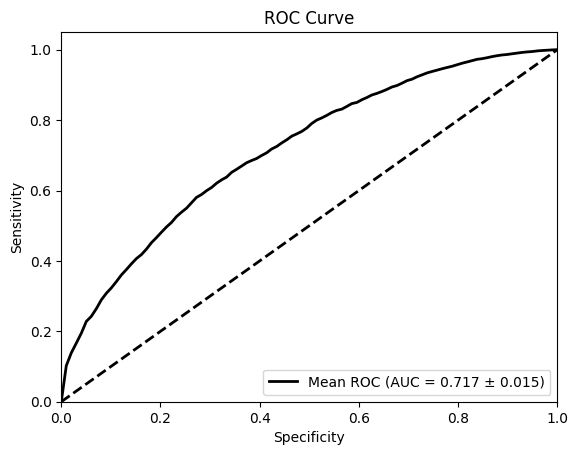

In [15]:
# 整体上预测疾病与健康的模型
ten_cv_plot, all_classifier = plot_roc_curve_with_cv(all_data_in)


In [23]:
ten_cv_plot.to_csv("ten_cv_plot_all.case_control.csv")

In [16]:
def roc_curve_with_cv_with_all_module(input_data, all_classifier):
    # 读取数据
    data = input_data  

    # 假设数据的最后一列是标签，其他列是特征
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]
    # 调用函数
    scores = cross_val_score(all_classifier, X, y, cv=10, scoring='accuracy')
    return scores

In [18]:
# 区分疾病类型
# cardiometabolic disease
cad_data = df_count_input_mp[df_count_input_mp['LevelA3'] == 'cardiometabolic disease']
cad_data = cad_data.drop(columns=['Sample', "BioProject", "Type", "LevelB", "LevelB1", "Project", "LevelA2", "LevelA3"])

## 添加标签列
cad_data['Label'] = cad_data['Group'].map({'Control': 0, 'Disease': 1})
cad_data_in = cad_data.drop(columns="Group")

In [19]:
cad_score = roc_curve_with_cv_with_all_module(cad_data_in, all_classifier)
print(cad_score.mean())
print(cad_score.std())

0.5418360995850623
0.1268331427660315


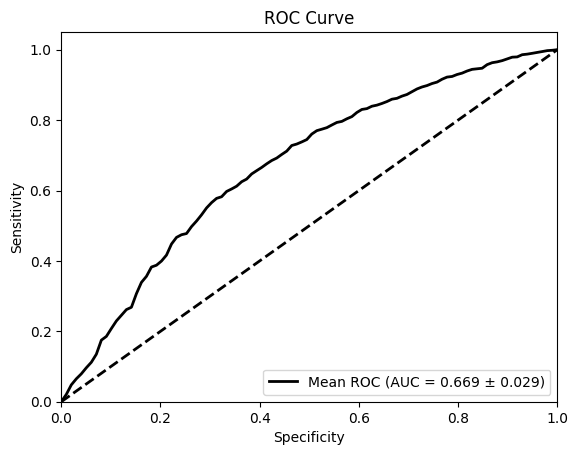

In [20]:
cad_data_in_plot = plot_roc_curve_with_cv(cad_data_in) 

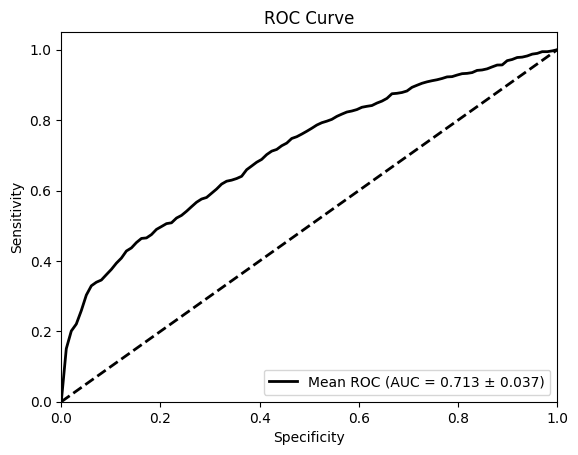

In [24]:
## cancer
cancer_data = df_count_input_mp[df_count_input_mp['LevelA3'] == 'cancer']
cancer_data = cancer_data.drop(columns=['Sample', "BioProject", "Type", "LevelB", "LevelB1", "Project", "LevelA2", "LevelA3"])

## 添加标签列
cancer_data['Label'] = cancer_data['Group'].map({'Control': 0, 'Disease': 1})
cancer_data_in = cancer_data.drop(columns="Group")

# 调用函数
cancer_data_in_plot = plot_roc_curve_with_cv(cancer_data_in)  

In [69]:
cancer_score = roc_curve_with_cv_with_all_module(cancer_data_in, all_classifier)
print(cancer_score.mean())
print(cancer_score.std())

0.5777963875205254
0.035554799931169584


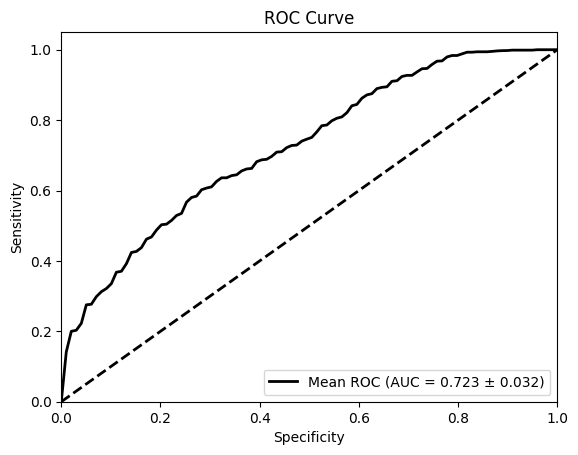

In [25]:
# immune disease
immune_data = df_count_input_mp[df_count_input_mp['LevelA3'] == 'immune disease']
immune_data = immune_data.drop(columns=['Sample', "BioProject", "Type", "LevelB", "LevelB1", "Project", "LevelA2", "LevelA3"])

## 添加标签列
immune_data['Label'] = immune_data['Group'].map({'Control': 0, 'Disease': 1})
immune_data_in = immune_data.drop(columns="Group")

# 调用函数
immune_data_in_plot = plot_roc_curve_with_cv(immune_data_in)  

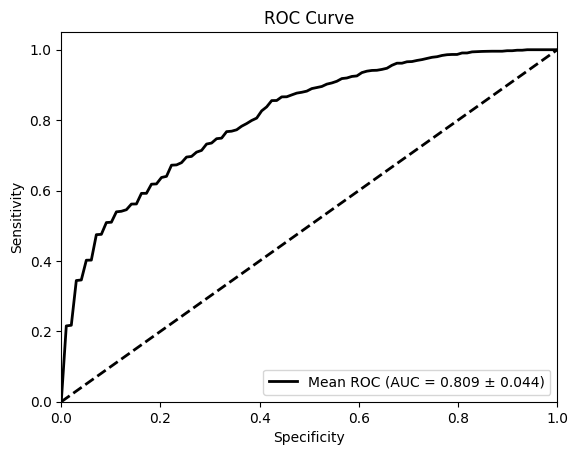

In [26]:
# digestive disease
digestive_data = df_count_input_mp[df_count_input_mp['LevelA3'] == 'digestive disease']
digestive_data = digestive_data.drop(columns=['Sample', "BioProject", "Type", "LevelB", "LevelB1", "Project", "LevelA2", "LevelA3"])

## 添加标签列
digestive_data['Label'] = digestive_data['Group'].map({'Control': 0, 'Disease': 1})
digestive_data_in = digestive_data.drop(columns="Group")

# 调用函数
digestive_data_in_plot = plot_roc_curve_with_cv(digestive_data_in)  

In [73]:
# mental disease
mental_data = df_count_input_mp[df_count_input_mp['LevelA3'] == 'mental disease']
mental_data = mental_data.drop(columns=['Sample', "BioProject", "Type", "LevelB", "LevelB1", "Project", "LevelA2", "LevelA3"])

## 添加标签列
mental_data['Label'] = mental_data['Group'].map({'Control': 0, 'Disease': 1})
mental_data_in = mental_data.drop(columns="Group")

# # 调用函数
mental_data_in_plot = plot_roc_curve_with_cv(mental_data_in)  

In [74]:
# nerve disease
nerve_data = df_count_input_mp[df_count_input_mp['LevelA3'] == 'nerve disease']
nerve_data = nerve_data.drop(columns=['Sample', "BioProject", "Type", "LevelB", "LevelB1", "Project", "LevelA2", "LevelA3"])

## 添加标签列
nerve_data['Label'] = nerve_data['Group'].map({'Control': 0, 'Disease': 1})
nerve_data_in = nerve_data.drop(columns="Group")

# # 调用函数
nerve_data_in_plot = plot_roc_curve_with_cv(nerve_data_in)  

In [31]:
cad_data_in_plot

(         fpr       tpr
 0   0.000000  0.000000
 1   0.010101  0.020613
 2   0.020202  0.047853
 3   0.030303  0.065090
 4   0.040404  0.079226
 ..       ...       ...
 95  0.959596  0.992330
 96  0.969697  0.994820
 97  0.979798  0.997415
 98  0.989899  0.998425
 99  1.000000  1.000000
 
 [100 rows x 2 columns],
 RandomForestClassifier(n_estimators=999, random_state=42))

In [32]:
cad_roc_data = cad_data_in_plot[0]
cad_roc_data["Label"] = "cardiometabolic disease"

In [33]:
## 合并数据集
# ten_cv_plot
cad_roc_data = cad_data_in_plot[0]
cad_roc_data["Label"] = "cardiometabolic disease"

cancer_roc_data = cancer_data_in_plot[0]
cancer_roc_data["Label"] = "cancer"

immune_roc_data = immune_data_in_plot[0]
immune_roc_data["Label"] = "immune disease"

digestive_roc_data = digestive_data_in_plot[0]
digestive_roc_data["Label"] = "digestive disease"

# digestive_data_in_plot["Label"] = "digestive disease"
# mental_data_in_plot["Label"] = "mental disease"
# nerve_data_in_plot["Label"] = "nerve disease"


In [34]:
# 按行合并多个 DataFrame
result = pd.concat([cad_roc_data, cancer_roc_data, immune_roc_data, digestive_roc_data], axis=0)
result.to_csv("result.csv")

In [21]:
def loco_cv_evaluation(df, disease_type):
    """
    使用LOCO CV对随机森林模型进行评估，并保留每个数据集绘制AUC ROC曲线图的数据

    参数:
    df (pd.DataFrame): 包含数据的数据框
    disease_type (str): 要筛选的疾病大类

    返回:
    float: 平均AUC得分
    list: 每次交叉验证的AUC得分列表
    list: 每次交叉验证的left-out study group列表
    dict: 存储每次交叉验证的真实标签和预测概率
    """

    # 筛选特定疾病大类的数据
    data = df[df['LevelB1'] == disease_type]
    data = data.drop(columns=['Sample', "BioProject", "Type", "LevelB", "LevelB1", "LevelA2", "LevelA3"])

    # 初始化LabelEncoder
    label_encoder = LabelEncoder()
    group_encoder = LabelEncoder()

    # 转换标签列为数字
    data["Group"] = label_encoder.fit_transform(data["Group"])

    # 转换分组列为数字
    data["Project"] = group_encoder.fit_transform(data["Project"])

    # 分离特征和标签
    y = data["Group"]
    groups = data["Project"]
    X = data.drop(columns=['Group', "Project"])

    # 定义AUC评分
    auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

    # 存储每次交叉验证的结果
    scores = []
    left_out_studies = []
    roc_data = {'y_true': [], 'y_pred_proba': []}

    # 初始化随机森林模型
    rf_model = RandomForestClassifier(n_estimators=999, random_state=42)

    # 定义LOO CV
    logo_cv = LeaveOneGroupOut()

    for train_idx, test_idx in logo_cv.split(X, y, groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # 训练模型
        rf_model.fit(X_train, y_train)

        # 预测概率
        y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

        # 计算AUC分数
        auc_score = roc_auc_score(y_test, y_pred_proba)
        scores.append(auc_score)

        # 存储left-out study group
        left_out_study = groups.iloc[test_idx].unique()
        left_out_studies.append(left_out_study)

        # 存储真实标签和预测概率
        roc_data['y_true'].extend(y_test)
        roc_data['y_pred_proba'].extend(y_pred_proba)

    # 计算并返回平均AUC分数和每次交叉验证的AUC分数
    average_auc = np.mean(scores)
    return average_auc, scores, left_out_studies, roc_data


In [22]:
IBD_average_auc, IBD_score, IBD_left_out_studies, IBD_roc_data = loco_cv_evaluation(df_count_input_mp, "IBD")
print(IBD_average_auc)

0.700821777399559


In [36]:
CRC_average_auc, CRC_score, CRC_left_out_studies, CRC_roc_data = loco_cv_evaluation(df_count_input_mp, "CRC")
print(CRC_average_auc)

0.6498433442710871


In [37]:
PD_average_auc, PD_score, PD_left_out_studies, PD_roc_data = loco_cv_evaluation(df_count_input_mp, "PD")
print(PD_average_auc)

0.5047090507667431
